# Feature Engineering for Steel Price Forecasting

This notebook focuses on preparing our time series data for more advanced forecasting models by:

1. Testing for stationarity and transforming the data appropriately
2. Creating lag features to capture temporal patterns
3. Saving the engineered features for model training

Feature engineering is a critical step in time series forecasting that helps models capture temporal dependencies and patterns more effectively than raw data alone.

Steel data loaded successfully:


,value
date,
1982-06-01,100.0
1982-07-01,100.0
1982-08-01,100.0
1982-09-01,100.0
1982-10-01,99.6


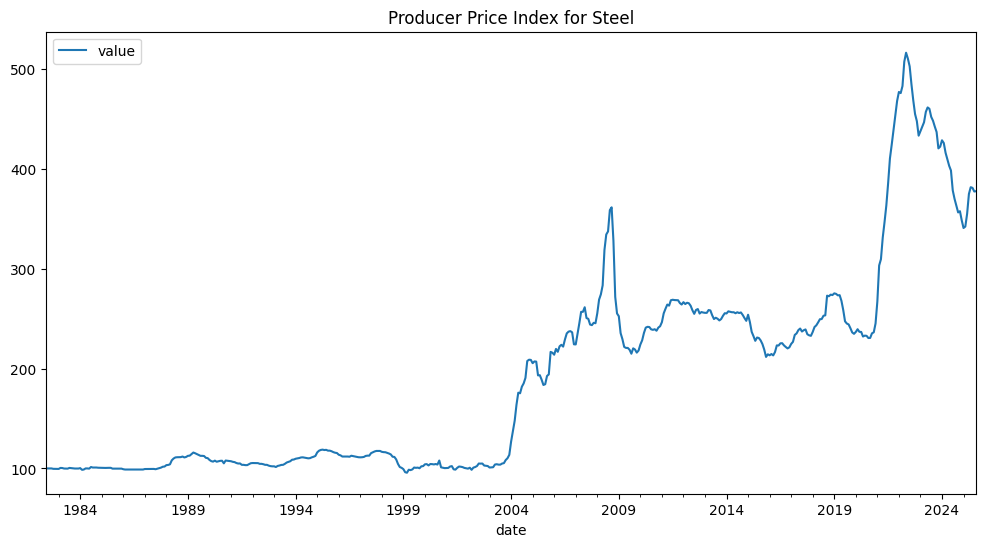

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# --- 1. SETUP & LOAD DATA ---
# Robust project root finder (works in notebook context)
def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root with one of markers not found.")

project_root = find_project_root()
dotenv_path = project_root / '.env'
load_dotenv(dotenv_path=dotenv_path)

DATABASE_URL = os.getenv("DATABASE_URL_ALEMBIC") or os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL_ALEMBIC or DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)

# Load only the steel data, set the date as the index
query = "SELECT date, value FROM raw_series WHERE series_id = 'PPI_STEEL' ORDER BY date"
steel_df = pd.read_sql(query, engine, index_col='date')
steel_df.index = pd.to_datetime(steel_df.index)
steel_df = steel_df.asfreq('MS')  # Ensure monthly frequency

print("Steel data loaded successfully:")
display(steel_df.head())
steel_df.plot(figsize=(12, 6), title='Producer Price Index for Steel')
plt.show()

## Data Setup and Loading

The first step in our analysis pipeline is to:
1. Set up the environment by finding the project root directory
2. Load environment variables for database connection
3. Connect to the database and retrieve our steel price index data
4. Configure the time series data properly (setting date index and frequency)

The Producer Price Index for Steel (PPI_STEEL) will be our target variable for forecasting. We'll visualize the raw data to understand its general trend and pattern.

In [2]:
from statsmodels.tsa.stattools import adfuller

# --- 2. STATIONARITY TEST ---
print("--- ADF Test on Raw Data ---")
result_raw = adfuller(steel_df['value'])
print(f'ADF Statistic: {result_raw[0]}')
print(f'p-value: {result_raw[1]}') # The important number

# Interpretation
if result_raw[1] > 0.05:
    print("Result: The p-value is greater than 0.05, so we fail to reject the null hypothesis. The data is NON-STATIONARY.")
else:
    print("Result: The p-value is less than or equal to 0.05, so we reject the null hypothesis. The data is STATIONARY.")

--- ADF Test on Raw Data ---
ADF Statistic: -1.2019958581517318
p-value: 0.6727365553761817
Result: The p-value is greater than 0.05, so we fail to reject the null hypothesis. The data is NON-STATIONARY.


## Testing for Stationarity

Stationarity is a crucial property for time series forecasting. A stationary time series has constant statistical properties over time (mean, variance, autocorrelation), making it easier to forecast.

We'll use the Augmented Dickey-Fuller (ADF) test to check if our steel price series is stationary:
- **Null hypothesis (H0)**: The series has a unit root (non-stationary)
- **Alternative hypothesis (H1)**: The series has no unit root (stationary)
- **Decision rule**: If p-value ≤ 0.05, reject H0 (series is stationary)

Non-stationary data often needs to be transformed before modeling.


--- ADF Test on Differenced Data ---
ADF Statistic: -8.219261288884804
p-value: 6.496210124202861e-13
Result: The p-value is less than or equal to 0.05. The data is now STATIONARY.


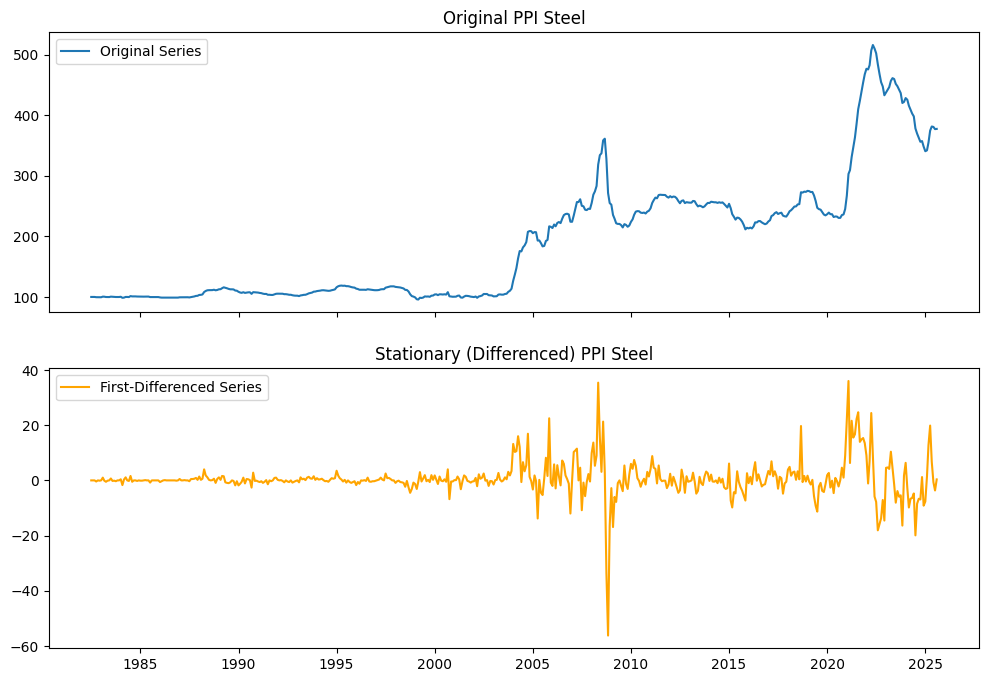

In [3]:
# --- 3. CREATE TRANSFORMED SERIES ---
steel_df['value_diff'] = steel_df['value'].diff()
steel_df.dropna(inplace=True) # Drop the first row which will have a NaN

print("\n--- ADF Test on Differenced Data ---")
result_diff = adfuller(steel_df['value_diff'])
print(f'ADF Statistic: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')

if result_diff[1] > 0.05:
    print("Result: The p-value is greater than 0.05. The data is still NON-STATIONARY.")
else:
    print("Result: The p-value is less than or equal to 0.05. The data is now STATIONARY.")

# Plot to visually confirm
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1.plot(steel_df['value'], label='Original Series')
ax1.set_title('Original PPI Steel')
ax1.legend()
ax2.plot(steel_df['value_diff'], label='First-Differenced Series', color='orange')
ax2.set_title('Stationary (Differenced) PPI Steel')
ax2.legend()
plt.show()

## Differencing for Stationarity

Since our raw steel price data is likely non-stationary (as is common with economic time series), we'll apply first-order differencing to transform it. 

Differencing is a common technique that:
- Computes period-to-period changes instead of absolute values
- Removes trends and some seasonal patterns
- Often transforms non-stationary data into stationary data

We'll:
1. Create a new column with the differenced values
2. Test the differenced series for stationarity using ADF test
3. Visualize both the original and differenced series to observe the transformation

In [4]:
# --- 4. BUILD LAG FEATURES ---
df_features = steel_df.copy()

for lag in [1, 3, 6, 12]:
    df_features[f'value_diff_lag_{lag}'] = df_features['value_diff'].shift(lag)

# Drop the NaN values created by the largest lag
df_features.dropna(inplace=True)

print("DataFrame with Lag Features:")
display(df_features.head())
display(df_features.tail())

DataFrame with Lag Features:


,value,value_diff,value_diff_lag_1,value_diff_lag_3,value_diff_lag_6,value_diff_lag_12
date,,,,,,
1983-07-01,100.5,0.7,0.0,-0.5,0.0,0.0
1983-08-01,100.3,-0.2,0.7,-0.1,1.0,0.0
1983-09-01,100.2,-0.1,-0.2,0.0,-0.1,0.0
1983-10-01,99.9,-0.3,-0.1,0.7,-0.5,-0.4
1983-11-01,99.9,0.0,-0.3,-0.2,-0.1,0.0


,value,value_diff,value_diff_lag_1,value_diff_lag_3,value_diff_lag_6,value_diff_lag_12
date,,,,,,
2025-04-01,374.697,19.861,12.770,-7.661,-6.907,-6.640
2025-05-01,381.435,6.738,19.861,1.463,1.212,-6.362
2025-06-01,380.775,-0.660,6.738,12.770,-9.151,-4.726
2025-07-01,377.119,-3.656,-0.660,19.861,-7.661,-19.910
2025-08-01,377.472,0.353,-3.656,6.738,1.463,-8.458


## Creating Lag Features

Now that we have a stationary series, we'll create lag features to help our models capture temporal patterns. Lag features represent past values of our target variable at different time points.

We'll create several lag features of our differenced series:
- **1-month lag**: Captures immediate short-term dependencies
- **3-month lag**: Captures quarterly effects
- **6-month lag**: Captures medium-term trends
- **12-month lag**: Captures annual seasonal patterns

These features provide the model with explicit information about past values, allowing it to learn temporal patterns and make more accurate forecasts.

In [5]:
# --- 5. EXPORT FEATURE SET ---
output_dir = project_root / 'ml' / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True) # Create the directory if it doesn't exist

output_path = output_dir / 'feature_store.parquet'
df_features.reset_index().to_parquet(output_path)

print(f"Feature set successfully saved to: {output_path}")

Feature set successfully saved to: /Users/vijaykhot/material-forecasting-engine/ml/data/processed/feature_store.parquet


## Exporting the Feature Store

In the final step, we save our engineered features to a Parquet file for later use in model training. The feature store will contain:
- The original target variable
- The stationary (differenced) target
- All lag features

Parquet is an efficient columnar storage format that:
- Preserves data types
- Provides efficient compression
- Enables faster read/write operations than CSV

The feature store can be loaded directly for model training and evaluation in subsequent notebooks.

## Summary and Next Steps

In this notebook, we've:

1. **Loaded and prepared** the raw steel price index data
2. **Tested for stationarity** and confirmed the raw data was non-stationary
3. **Transformed the data** by applying differencing to achieve stationarity
4. **Created lag features** at various time horizons (1, 3, 6, and 12 months)
5. **Exported the feature store** for use in subsequent modeling

These engineered features provide a solid foundation for training forecasting models. 

### Next Steps:

1. **Model Training**: Train various forecasting models (ARIMA, Prophet, machine learning models) using our feature store
2. **Model Evaluation**: Compare models using appropriate time series evaluation metrics
3. **Feature Importance Analysis**: Determine which lag features contribute most to prediction accuracy
4. **Hyperparameter Tuning**: Optimize model parameters for the best performing models
5. **Production Implementation**: Deploy the best model for ongoing steel price forecasting